# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de La Gomera

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    #plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.show()
    
def visualizar_historico(train, y_test, y_pred, variable, dias_historico, indices, tit, color, dif):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    plt.bar(indices, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    historico = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=2)
    
    return modelo, historico
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))
        
def visualizar_perdida(historico):
    plt.plot(historico.history['loss'], label='train')
    plt.plot(historico.history['val_loss'], label='test')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.title('Pérdida del modelo')
    plt.legend()
    plt.show() 

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_LaGomera = datos[datos['isla'] == 'LA GOMERA']

datos_LaGomera = datos_LaGomera.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'La Gomera'         # Isla a la que se está realziando el estudio
fechas = datos_LaGomera.tail(dias_prediccion).index # Fechas de los días a predecir
color_isla = 'olive' # Color de la isla en las visualizaciones
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train

variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:
# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_LaGomera_uni = datos_LaGomera[objetivo]
datos_LaGomera_uni_arr = np.array(datos_LaGomera_uni).reshape(-1, 1)

datos_LaGomera_mult_covid = datos_LaGomera[variables_covid]
datos_LaGomera_mult_atm = datos_LaGomera[variables_atm]
datos_LaGomera_mult_total = datos_LaGomera[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_uni_scaled = scaler.fit_transform(datos_LaGomera_uni_arr)

In [7]:
n_train = len(datos_LaGomera_uni_scaled) - dias_prediccion


train = datos_LaGomera_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_uni_scaled[n_train - dias_prediccion:len(datos_LaGomera_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 4s - loss: 0.0471 - val_loss: 0.1598 - 4s/epoch - 258ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0407 - val_loss: 0.1307 - 122ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0345 - val_loss: 0.0785 - 124ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0287 - val_loss: 0.0702 - 124ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0268 - val_loss: 0.0692 - 126ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0250 - val_loss: 0.0707 - 123ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0234 - val_loss: 0.0693 - 130ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0225 - val_loss: 0.0669 - 138ms/epoch - 10ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0217 - val_loss: 0.0653 - 132ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0200 - val_loss: 0.0662 - 140ms/epoch - 10ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0203 - val_loss: 0.0726 - 138ms/epoch - 10ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0189 - val_loss: 0.0712 - 128ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s 

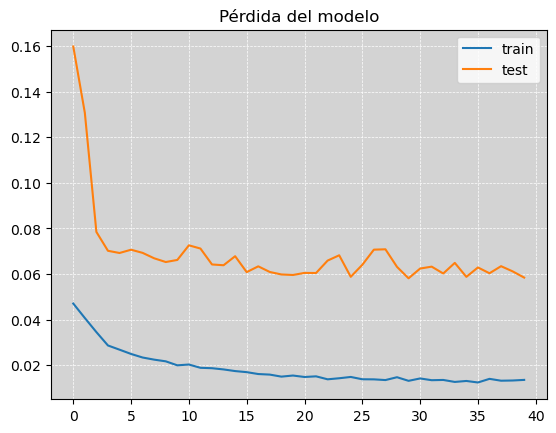

In [10]:
visualizar_perdida(historico)

In [11]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 330ms/step


In [12]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 25.753681
2022-03-20: número de casos reales 7, número de casos predichos 26.01359
2022-03-21: número de casos reales 53, número de casos predichos 25.21095
2022-03-22: número de casos reales 36, número de casos predichos 25.693634
2022-03-23: número de casos reales 32, número de casos predichos 26.358805
2022-03-24: número de casos reales 32, número de casos predichos 27.788044
2022-03-25: número de casos reales 27, número de casos predichos 25.700994
2022-03-26: número de casos reales 13, número de casos predichos 25.672035
2022-03-27: número de casos reales 14, número de casos predichos 24.163057
2022-03-28: número de casos reales 13, número de casos predichos 23.464146


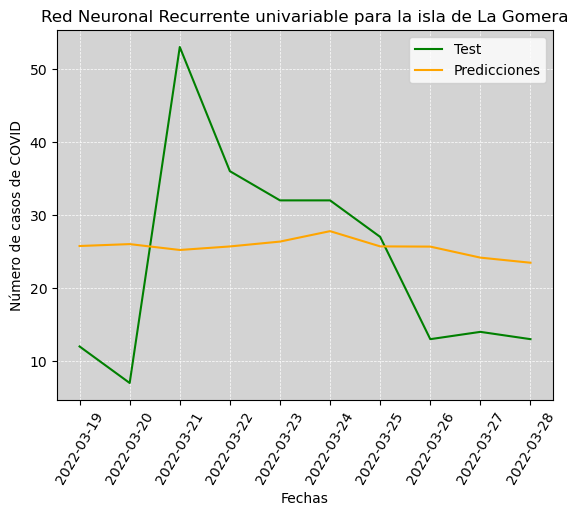

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [14]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-13.75368118, -19.01358986,  27.78904915,  10.30636597,
         5.6411953 ,   4.21195602,   1.29900551, -12.67203522,
       -10.16305733, -10.46414566])

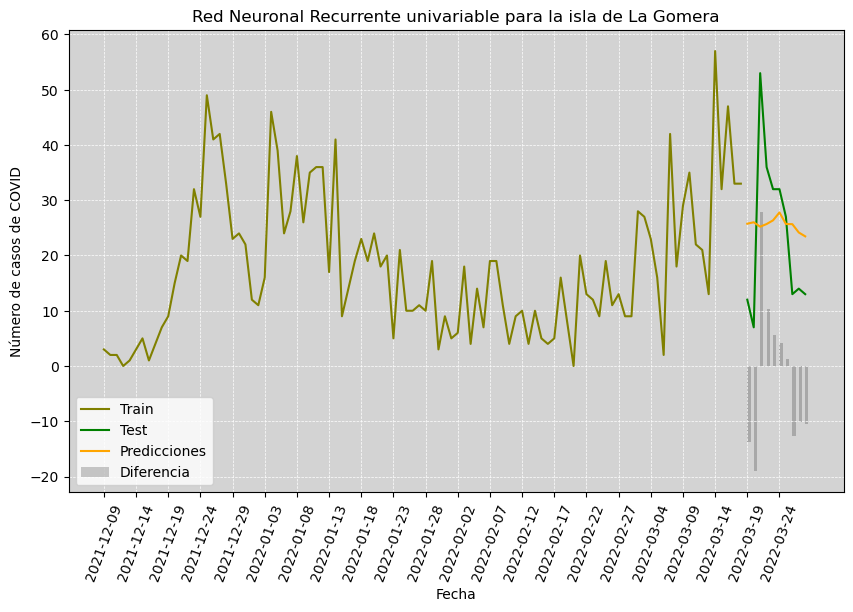

In [15]:
datos_train = datos_LaGomera_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',n_dias_train_vis,fechas,tit,color_isla,dif)

In [16]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 185.3750405858653
Error absoluto medio (MAE) del modelo: 11.53140811920166
Raíz del error cuadrático medio (RMSE) del modelo: 13.615250294646268


# Red Neuronal Recurrente multivariable con variables de pandemia

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_covid_scaled = scaler.fit_transform(datos_LaGomera_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaGomera_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_LaGomera_mult_covid_scaled) - dias_prediccion


train = datos_LaGomera_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_mult_covid_scaled[n_train - dias_prediccion:len(datos_LaGomera_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0454 - val_loss: 0.1468 - 3s/epoch - 223ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0385 - val_loss: 0.1056 - 129ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0332 - val_loss: 0.0863 - 131ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0283 - val_loss: 0.0676 - 130ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0253 - val_loss: 0.0722 - 132ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0250 - val_loss: 0.0680 - 129ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0241 - val_loss: 0.0651 - 129ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0225 - val_loss: 0.0684 - 130ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0213 - val_loss: 0.0638 - 132ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0209 - val_loss: 0.0637 - 130ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0205 - val_loss: 0.0625 - 130ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0183 - val_loss: 0.0632 - 128ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - l

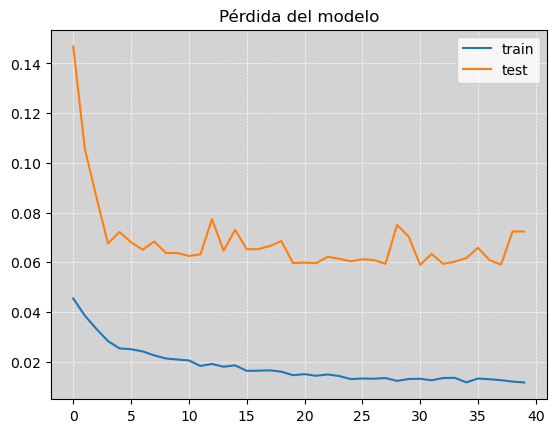

In [21]:
visualizar_perdida(historico)

In [22]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 282ms/step


In [23]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 31.56155
2022-03-20: número de casos reales 7, número de casos predichos 31.689907
2022-03-21: número de casos reales 53, número de casos predichos 30.789803
2022-03-22: número de casos reales 36, número de casos predichos 30.993807
2022-03-23: número de casos reales 32, número de casos predichos 31.4915
2022-03-24: número de casos reales 32, número de casos predichos 32.779243
2022-03-25: número de casos reales 27, número de casos predichos 30.762522
2022-03-26: número de casos reales 13, número de casos predichos 30.47601
2022-03-27: número de casos reales 14, número de casos predichos 29.125113
2022-03-28: número de casos reales 13, número de casos predichos 28.496952


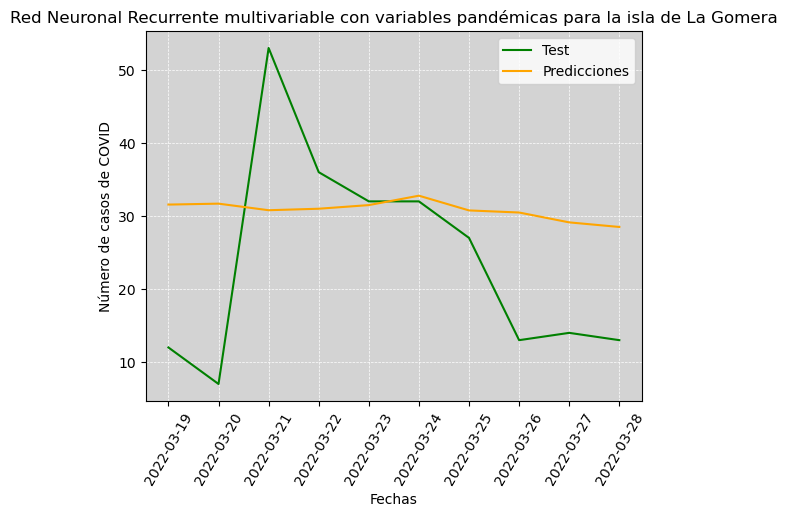

In [24]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [25]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-19.56155014, -24.68990707,  22.21019745,   5.00619316,
         0.50849915,  -0.77924347,  -3.76252174, -17.47600937,
       -15.12511253, -15.49695206])

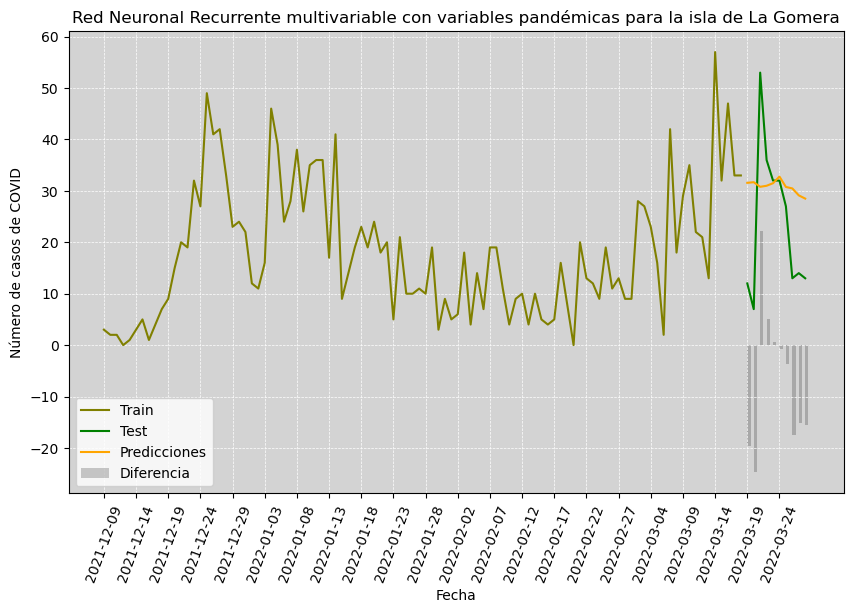

In [26]:
datos_train = datos_LaGomera_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [27]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 229.99584131990667
Error absoluto medio (MAE) del modelo: 12.461618614196777
Raíz del error cuadrático medio (RMSE) del modelo: 15.165613779860895


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_atm_scaled = scaler.fit_transform(datos_LaGomera_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaGomera_mult_atm[objetivo]).reshape(-1, 1))

In [29]:
n_train = len(datos_LaGomera_mult_atm_scaled) - dias_prediccion


train = datos_LaGomera_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_mult_atm_scaled[n_train - dias_prediccion:len(datos_LaGomera_mult_atm_scaled), :]

In [30]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [31]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0491 - val_loss: 0.1747 - 3s/epoch - 207ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0429 - val_loss: 0.1367 - 131ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0370 - val_loss: 0.1117 - 125ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0324 - val_loss: 0.0770 - 125ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0289 - val_loss: 0.0735 - 124ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0264 - val_loss: 0.0713 - 124ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0244 - val_loss: 0.0745 - 127ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0237 - val_loss: 0.0680 - 126ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0218 - val_loss: 0.0686 - 124ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0207 - val_loss: 0.0670 - 125ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0206 - val_loss: 0.0670 - 123ms/epoch - 9ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0202 - val_loss: 0.0660 - 124ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - l

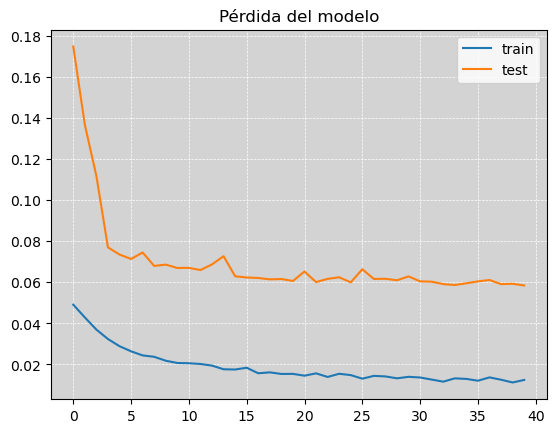

In [32]:
visualizar_perdida(historico)

In [33]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 467ms/step


In [34]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 24.17322
2022-03-20: número de casos reales 7, número de casos predichos 24.31614
2022-03-21: número de casos reales 53, número de casos predichos 23.731785
2022-03-22: número de casos reales 36, número de casos predichos 23.815655
2022-03-23: número de casos reales 32, número de casos predichos 24.01596
2022-03-24: número de casos reales 32, número de casos predichos 24.721045
2022-03-25: número de casos reales 27, número de casos predichos 23.630558
2022-03-26: número de casos reales 13, número de casos predichos 23.66386
2022-03-27: número de casos reales 14, número de casos predichos 22.653162
2022-03-28: número de casos reales 13, número de casos predichos 22.001411


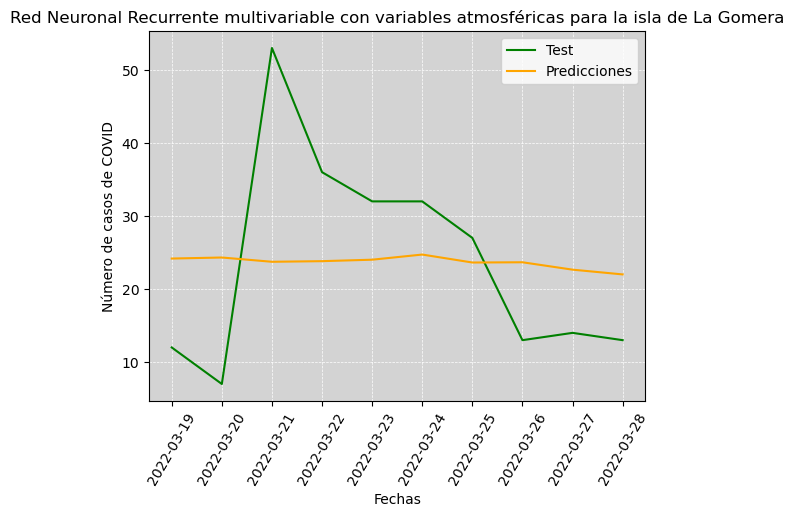

In [35]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [36]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-12.17321968, -17.31613922,  29.26821518,  12.18434525,
         7.98403931,   7.27895546,   3.36944199, -10.66386032,
        -8.653162  ,  -9.00141144])

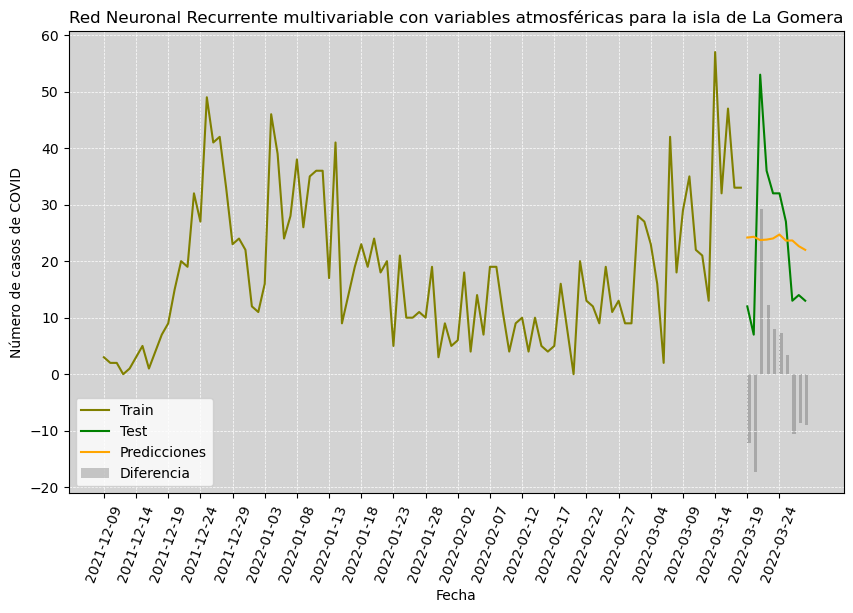

In [37]:
datos_train = datos_LaGomera_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [38]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 185.0824396768363
Error absoluto medio (MAE) del modelo: 11.789278984069824
Raíz del error cuadrático medio (RMSE) del modelo: 13.604500713985658


# Red Neuronal Recurrente multivariable con todas las variables

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_total_scaled = scaler.fit_transform(datos_LaGomera_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaGomera_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaGomera_mult_total[objetivo]).reshape(-1, 1))

In [40]:
n_train = len(datos_LaGomera_mult_total_scaled) - dias_prediccion


train = datos_LaGomera_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaGomera_mult_total_scaled[n_train - dias_prediccion:len(datos_LaGomera_mult_total_scaled), :]

In [41]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [42]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0433 - val_loss: 0.1678 - 3s/epoch - 212ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0348 - val_loss: 0.1090 - 161ms/epoch - 11ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0296 - val_loss: 0.0779 - 157ms/epoch - 11ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0259 - val_loss: 0.0654 - 158ms/epoch - 11ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0237 - val_loss: 0.0700 - 158ms/epoch - 11ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0221 - val_loss: 0.0642 - 156ms/epoch - 11ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0216 - val_loss: 0.0638 - 155ms/epoch - 11ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0209 - val_loss: 0.0691 - 156ms/epoch - 11ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0202 - val_loss: 0.0672 - 155ms/epoch - 11ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0178 - val_loss: 0.0620 - 156ms/epoch - 11ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0172 - val_loss: 0.0648 - 155ms/epoch - 11ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0181 - val_loss: 0.0619 - 158ms/epoch - 11ms/step
Epoch 13/40
14/

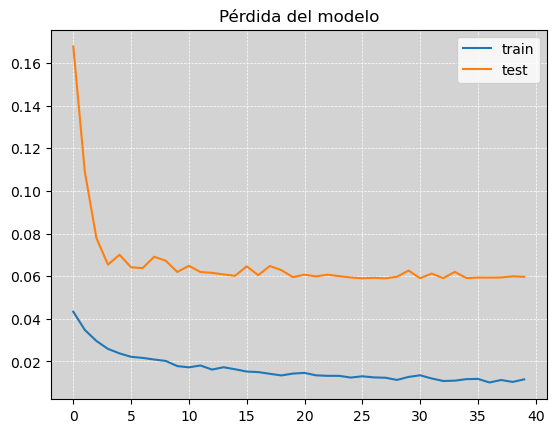

In [43]:
visualizar_perdida(historico)

In [44]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 285ms/step


In [45]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 12, número de casos predichos 25.737303
2022-03-20: número de casos reales 7, número de casos predichos 25.651295
2022-03-21: número de casos reales 53, número de casos predichos 25.001104
2022-03-22: número de casos reales 36, número de casos predichos 24.874657
2022-03-23: número de casos reales 32, número de casos predichos 24.931938
2022-03-24: número de casos reales 32, número de casos predichos 25.410437
2022-03-25: número de casos reales 27, número de casos predichos 25.274445
2022-03-26: número de casos reales 13, número de casos predichos 25.107552
2022-03-27: número de casos reales 14, número de casos predichos 24.232542
2022-03-28: número de casos reales 13, número de casos predichos 23.53472


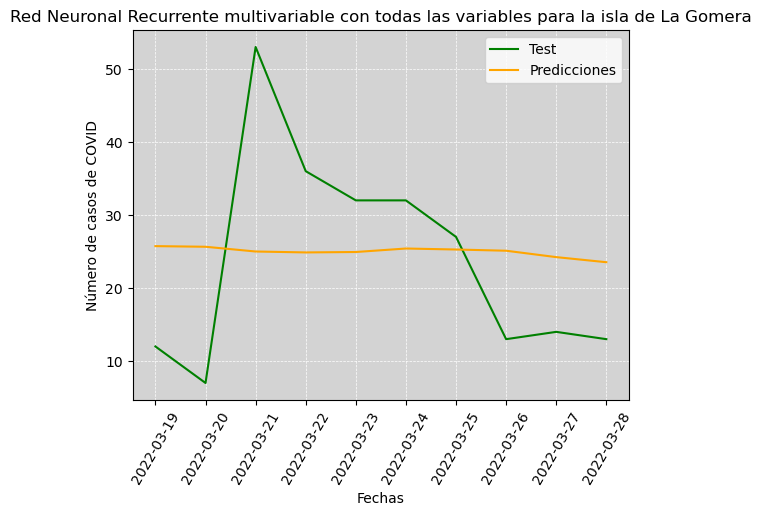

In [46]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [47]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-13.73730278, -18.65129471,  27.99889565,  11.12534332,
         7.06806183,   6.58956337,   1.72555542, -12.10755157,
       -10.23254204, -10.53471947])

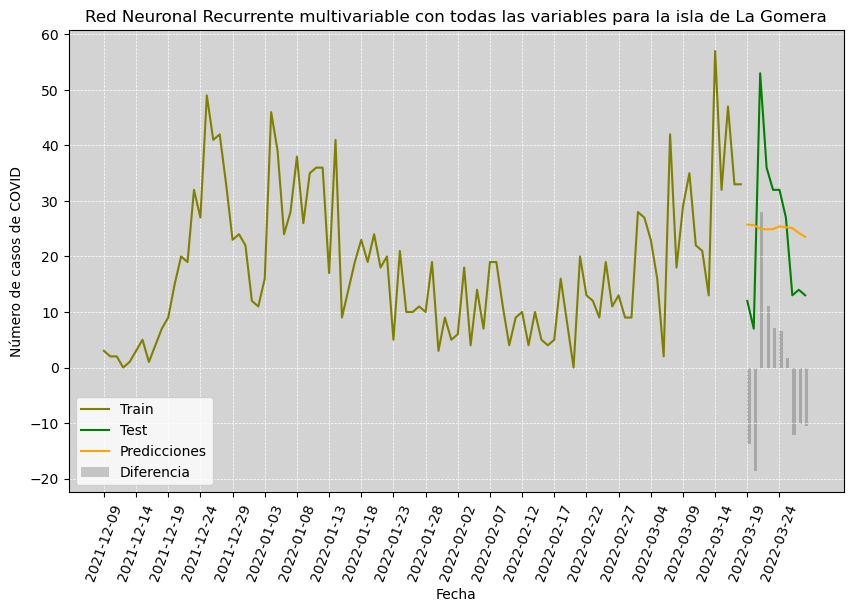

In [48]:
datos_train = datos_LaGomera_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [49]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 190.29311242332952
Error absoluto medio (MAE) del modelo: 11.977083015441895
Raíz del error cuadrático medio (RMSE) del modelo: 13.794676959730863
